This is an updated version of an [earlier post](http://rdkit.blogspot.com/2019/12/using-r-group-decomposition-code.html).

The RDKit's code for doing R-group decomposition (RGD) is quite flexible but also rather "undocumented". Thanks to that fact, you may not be aware of some of the cool stuff that's there. This post is an attempt to at least begin to remedy that by looking at some of the edge cases that come up while doing RGD. 

I have another post coming in the near future which is a bit more of a tutorial, but here we'll look at a number of difficult/interesting problems that arise all the time when doing RGD on real-world datasets:

- Handling symmetric cores
- Handling stereochemistry
- Handling sidechains that attach to the core at more than one point
- Handling multiple scaffolds or variable scaffolds

Some of these problems are really tricky to solve perfectly, so please expect that there will be bugs (particularly in the code for handling symmetrization). If you find something that seems wrong, please do file a bug report, ideally with the exact code and structures that you used.

The code in this blog post behaves correctly with v2019.09.1 and later of the RDKit. Older versions have bugs that generate different results for some of the examples here.    

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import rdRGroupDecomposition
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
import rdkit
print(rdkit.__version__)


2022.09.1


In [2]:
PandasTools.RenderImagesInAllDataFrames()

# Basics: a symmetric core

Let's start with an easy example that has a symmetric core. In this case R1 and R5 are symmetry equivalent as are R2 and R4):

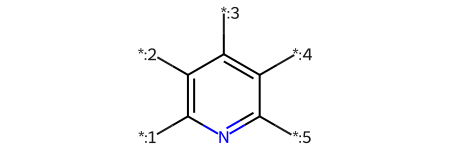

In [3]:
scaffold = Chem.MolFromSmiles('[*:1]c1c([*:2])c([*:3])c([*:4])c([*:5])n1')
scaffold

Here are some molecules that share that scaffold. We've provided the atoms in different orders to make sure that's properly handled by the RGD code.

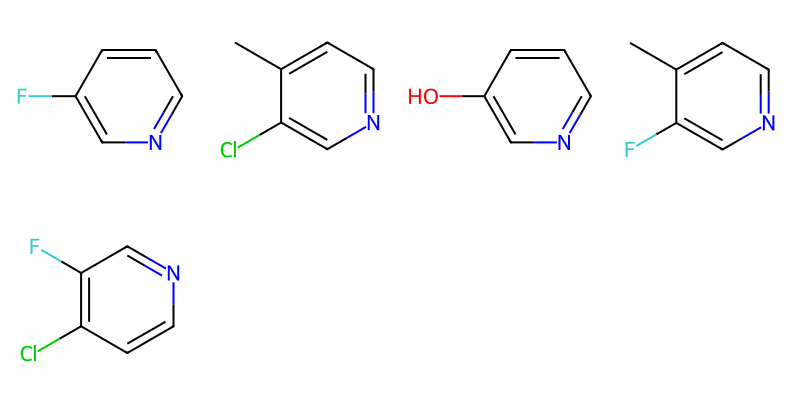

In [4]:
mols = [Chem.MolFromSmiles(smi) for smi in 'c1c(F)cccn1 c1c(Cl)c(C)ccn1 c1c(O)cccn1 c1c(F)c(C)ccn1 c1cc(Cl)c(F)cn1'.split()]
Draw.MolsToGridImage(mols,molsPerRow=4)

Do a version where we provide a scaffold without the R labels to start with:

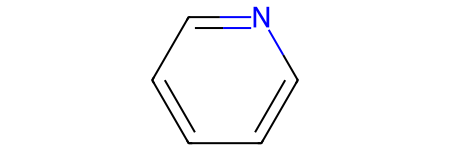

In [5]:
scaffold = Chem.MolFromSmiles('c1ccccn1')
scaffold

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,

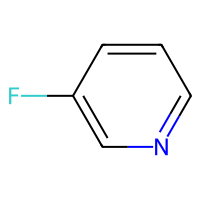
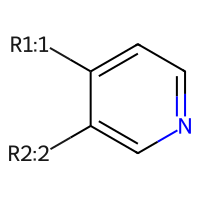
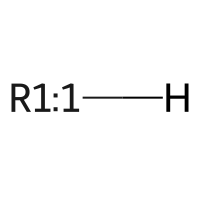
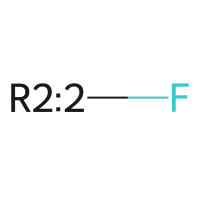
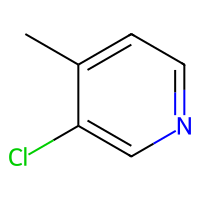
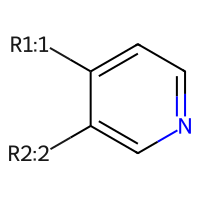
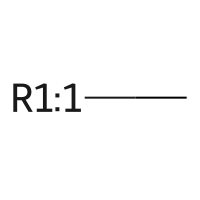
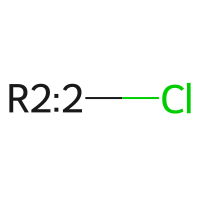
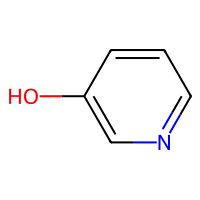
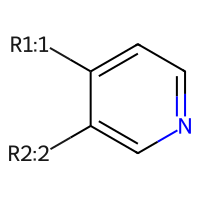
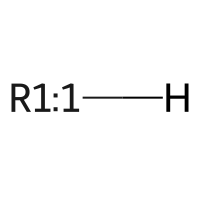
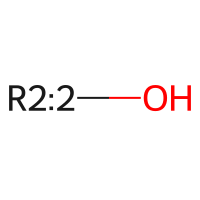
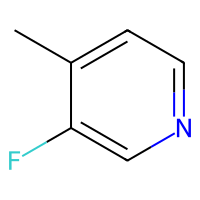
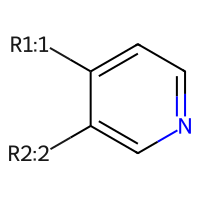
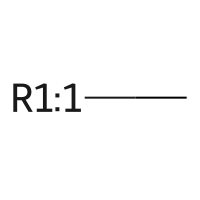
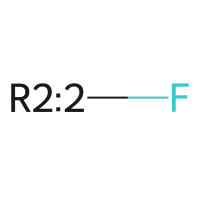
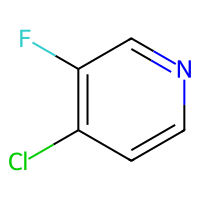
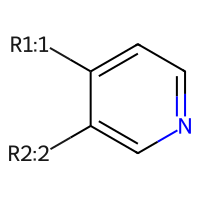
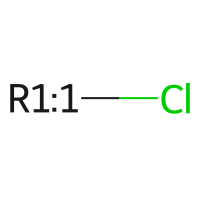
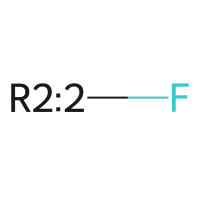

In [6]:
groups,_ = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=False,asRows=False) 
PandasTools.RGroupDecompositionToFrame(groups,mols,include_core=True)

Those labels were automatically assigned and they aren't consistent with what we had above. Notice, however, that the symmetry in the scaffold has been properly handled. 

If we care about the R group labels, We can explicitly label the side chains:

,Mol,Core,R2,R3
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,

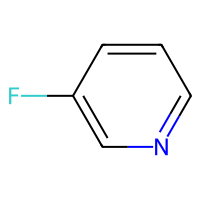
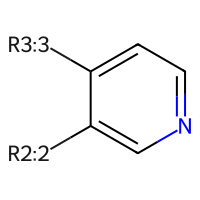
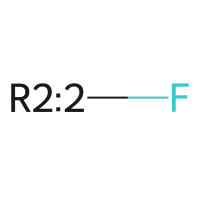
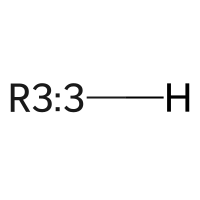
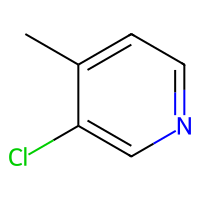
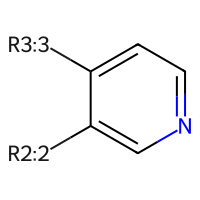
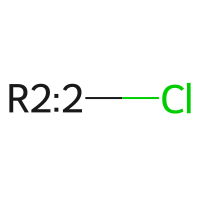
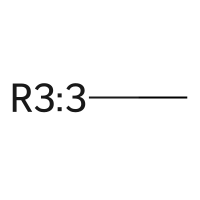
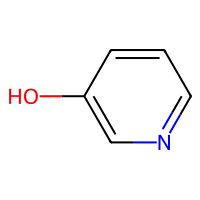
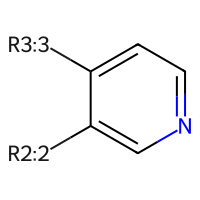
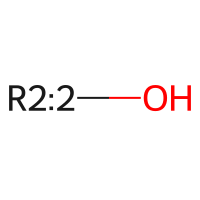
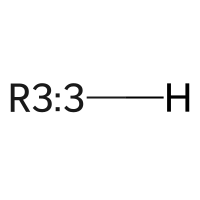
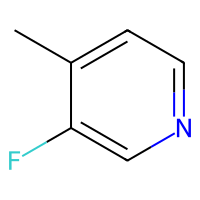
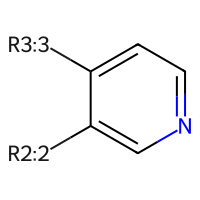
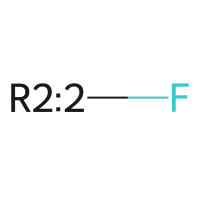
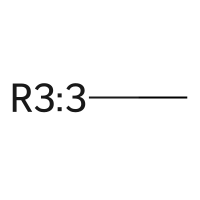
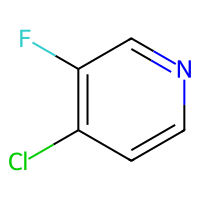
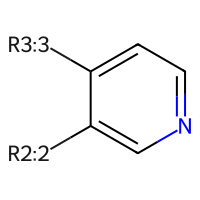
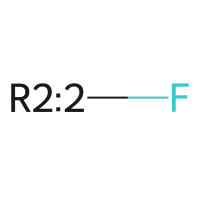
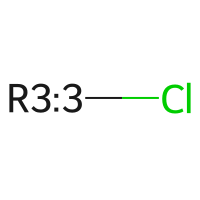

In [7]:
# note: there's a bug in RDKit 2019.03.3 and 2019.03.4 that causes this to generate different
# results with those versions
scaffold = Chem.MolFromSmiles('c1c([*:2])c([*:3])ccn1')
groups,_ = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=False,asRows=False) 
PandasTools.RGroupDecompositionToFrame(groups,mols,include_core=True)

We've just been looking at compound images since that's a bit more readable. Here's what the raw output from the function looks like:

In [8]:
groups,_ = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=True,asRows=False) 
print(groups)

{'Core': ['c1cc([*:3])c([*:2])cn1', 'c1cc([*:3])c([*:2])cn1', 'c1cc([*:3])c([*:2])cn1', 'c1cc([*:3])c([*:2])cn1', 'c1cc([*:3])c([*:2])cn1'], 'R2': ['F[*:2]', 'Cl[*:2]', 'O[*:2]', 'F[*:2]', 'F[*:2]'], 'R3': ['[H][*:3]', 'C[*:3]', '[H][*:3]', 'C[*:3]', 'Cl[*:3]']}


We can also get that in a row-oriented format:

In [9]:
groups,_ = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=True,asRows=True) 
print(groups)

[{'Core': 'c1cc([*:3])c([*:2])cn1', 'R2': 'F[*:2]', 'R3': '[H][*:3]'}, {'Core': 'c1cc([*:3])c([*:2])cn1', 'R2': 'Cl[*:2]', 'R3': 'C[*:3]'}, {'Core': 'c1cc([*:3])c([*:2])cn1', 'R2': 'O[*:2]', 'R3': '[H][*:3]'}, {'Core': 'c1cc([*:3])c([*:2])cn1', 'R2': 'F[*:2]', 'R3': 'C[*:3]'}, {'Core': 'c1cc([*:3])c([*:2])cn1', 'R2': 'F[*:2]', 'R3': 'Cl[*:3]'}]


# Stereochemistry

Making sure that the sidechains are labelled correctly on chiral centers can be a bit trickier.

Here's a set of molecules we'll be using. Some have a chiral center, some don't. There are a few that have sidechains with dual attachment points (i.e. rings). We'll look at those in the next section.

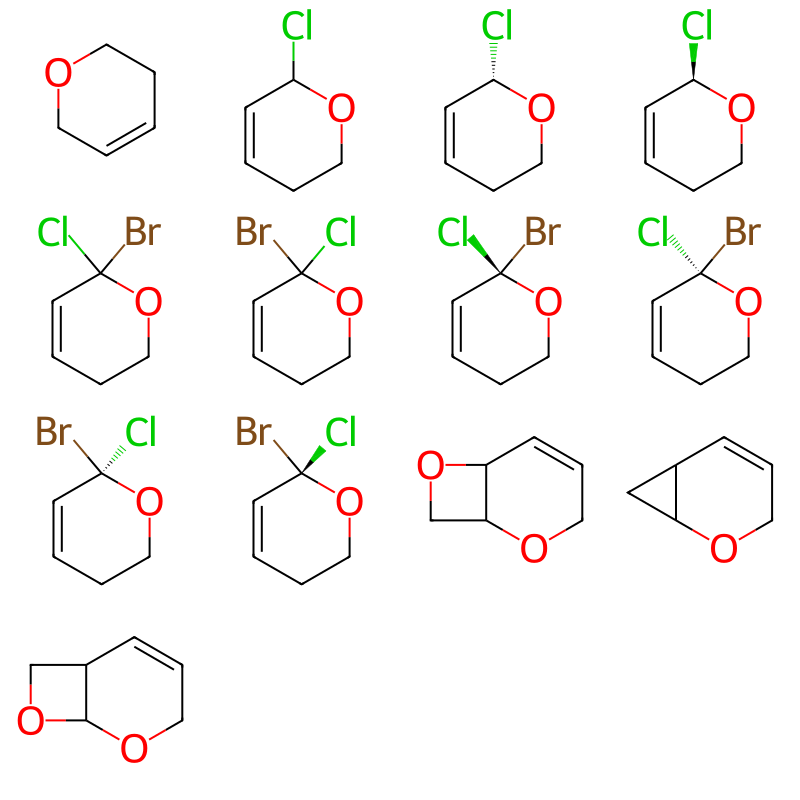

In [10]:
mols = [x for x in Chem.SDMolSupplier('../data/rgd_chiral.sdf')]
Draw.MolsToGridImage(mols,molsPerRow=4)

Remove the examples with "ring" sidechains. We'll get to those later

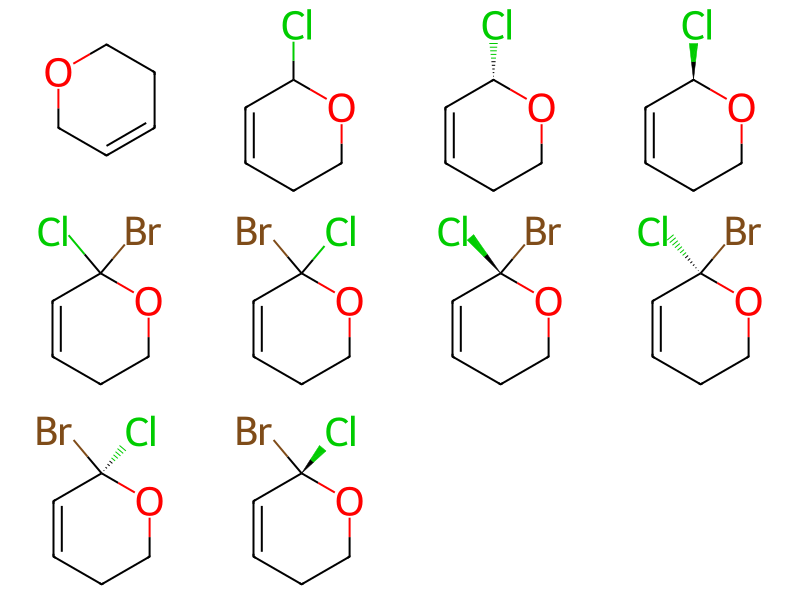

In [11]:
q = Chem.MolFromSmarts('[R2]')
mols = [x for x in mols if not x.HasSubstructMatch(q)]
Draw.MolsToGridImage(mols,molsPerRow=4)

We'll define two scaffolds, the first with a chiral center, the second without. In this case we will add explicit markers for the substituents. This is currently (v2019.09) necessary to properly handle atomic chirality.

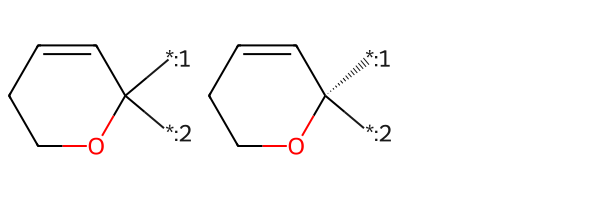

In [12]:
scaffold = Chem.MolFromSmiles('[*:1]C1([*:2])OCCC=C1')
chiral_scaffold = Chem.MolFromSmiles('[*:1][C@]1([*:2])OCCC=C1')
Draw.MolsToGridImage([scaffold,chiral_scaffold])

Start with doing a decomposition with the non-chiral scaffold. This matches all the molecules, but generates results that are not consistent with the chirality. The compounds in rows 2 and 3 (numbered from zero) demonstrate the problem clearly.

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,
7,,,,
8,,,,
9,,,,

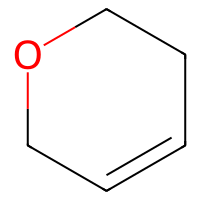
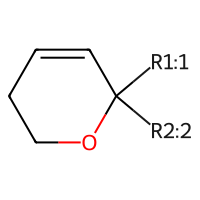
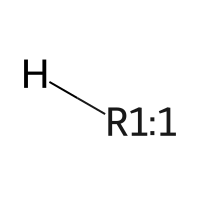
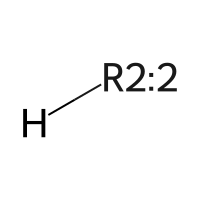
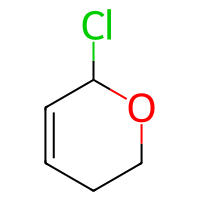
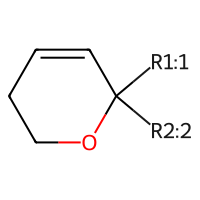
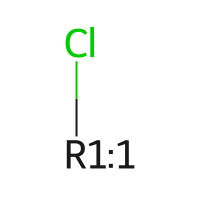
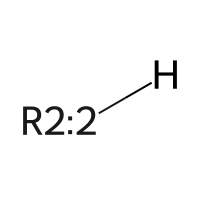
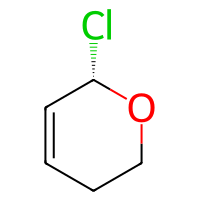
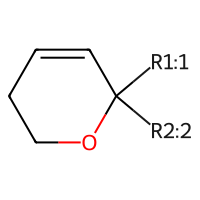
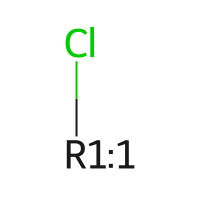
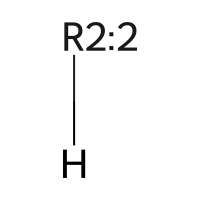
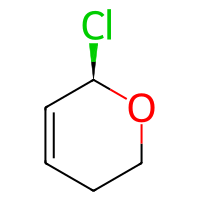
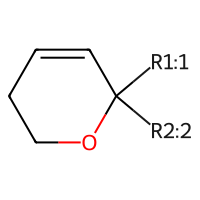
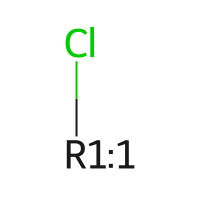
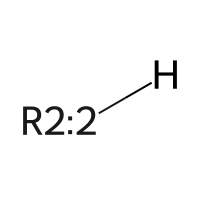
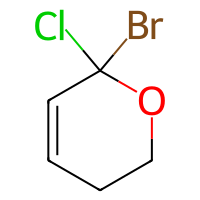
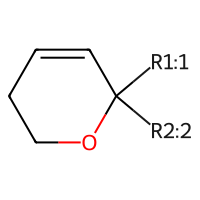
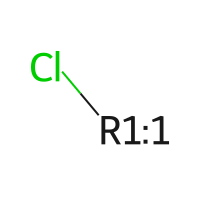
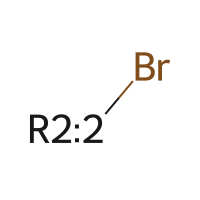
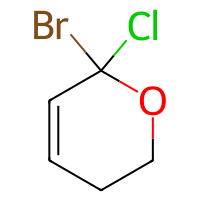
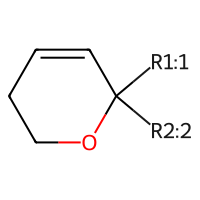
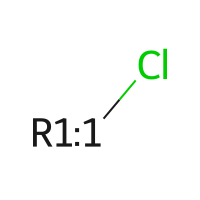
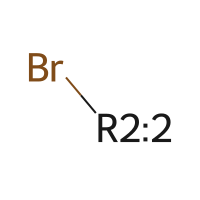
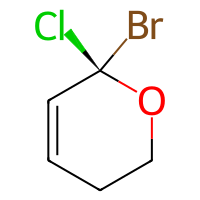
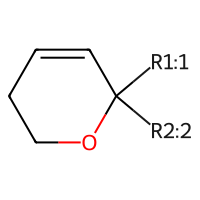
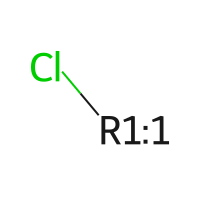
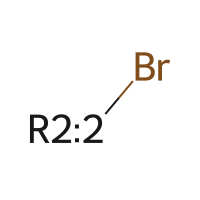
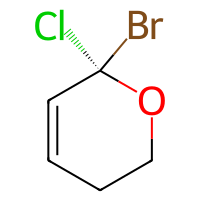
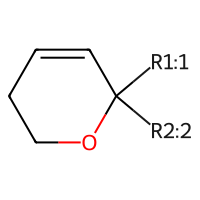
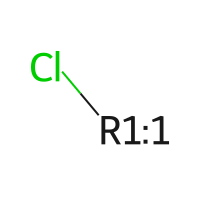
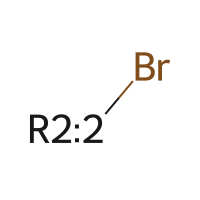
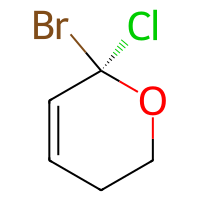
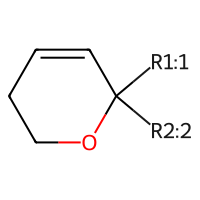
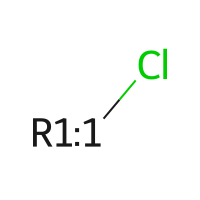
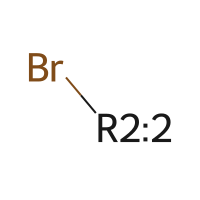
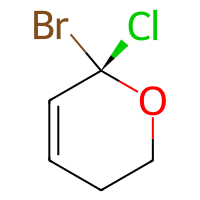
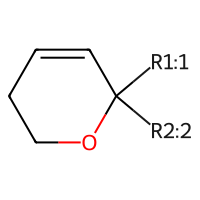
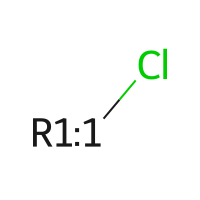
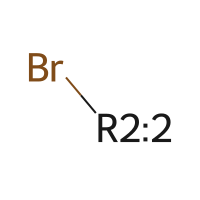

In [13]:
groups,_ = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=False,asRows=False) 
PandasTools.RGroupDecompositionToFrame(groups,mols,include_core=True)

Try the chiral scaffold. This one will only match the chiral compounds, but it does the right thing with those:

[13:50:06] No core matches
[13:50:06] No core matches
[13:50:06] No core matches
[13:50:06] No core matches


,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,

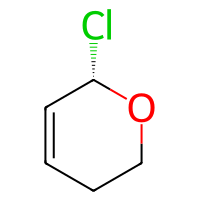
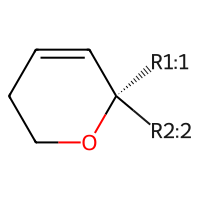
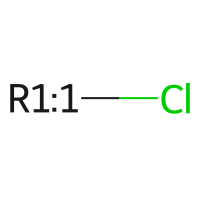
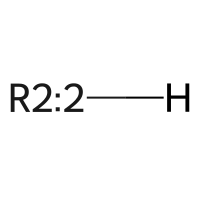
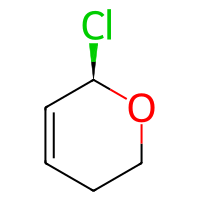
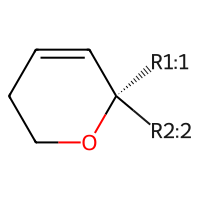
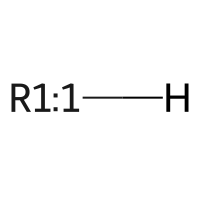
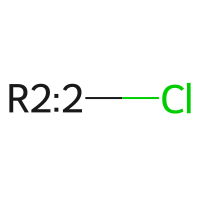
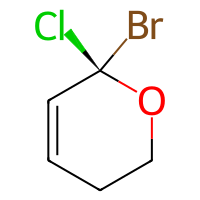
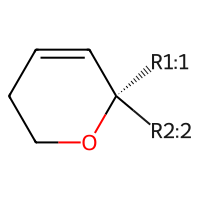
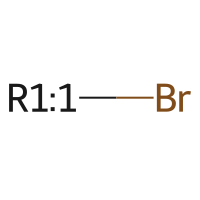
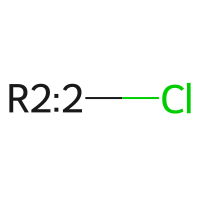
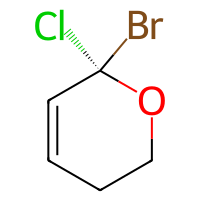
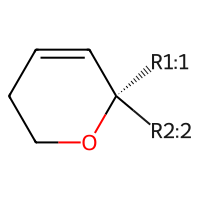
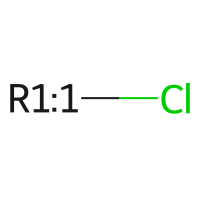
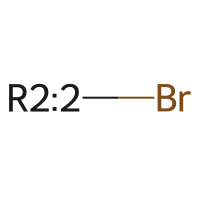
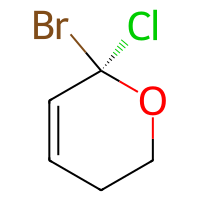
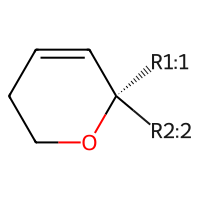
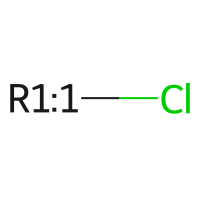
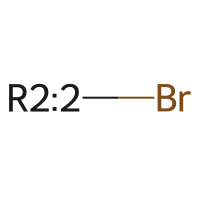
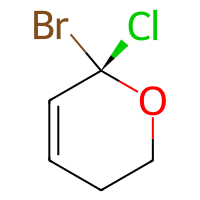
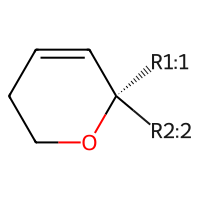
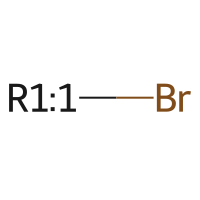
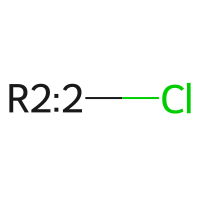

In [14]:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([chiral_scaffold],mols,asSmiles=False,asRows=False)
tmols = [mols[x] for x in range(len(mols)) if x not in unmatched]
PandasTools.RGroupDecompositionToFrame(groups,tmols,include_core=True,redraw_sidechains=True)

Note that in each case the atom is assigned to the correct R group.

We can also combine the two scaffolds so that we can get the chiral and achiral cases. Order is important, so we include the more specific scaffold (the chiral one) first. In this case the stereochemistry determines the R1/R2 assignment for the chiral molecules. For the non-chiral molecules R1 and R2 are assigned using the standard symmetrization code.

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,
7,,,,
8,,,,
9,,,,

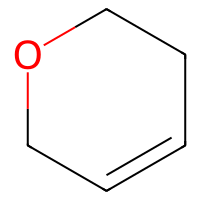
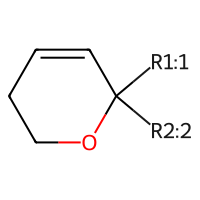
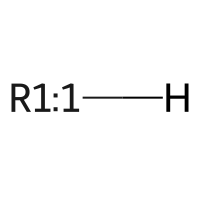
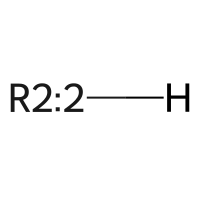
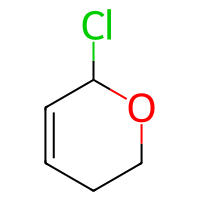
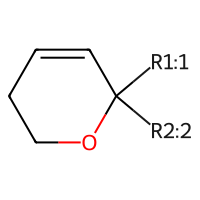
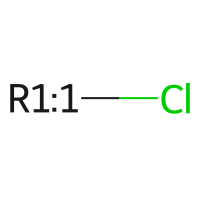
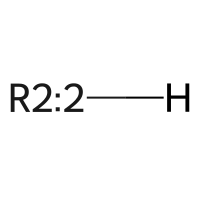
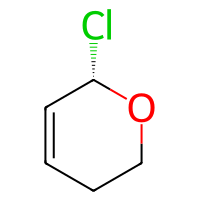
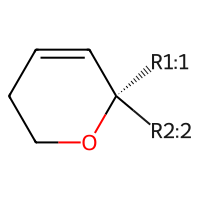
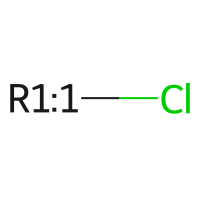
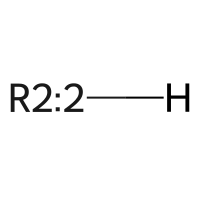
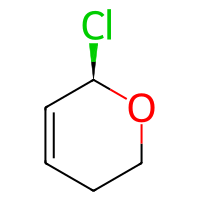
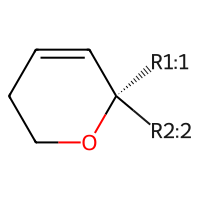
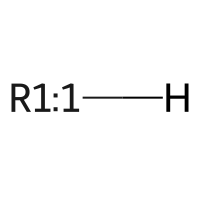
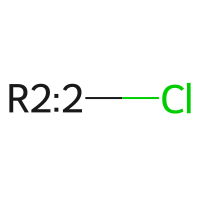
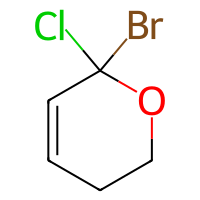
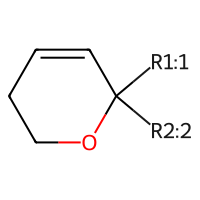
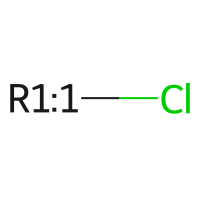
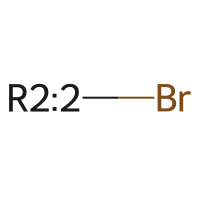
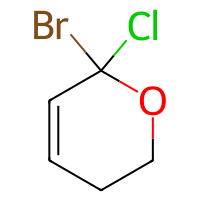
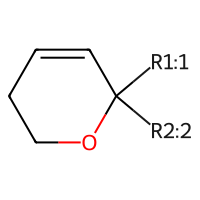
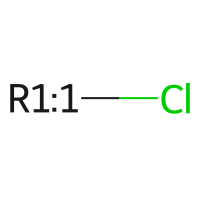
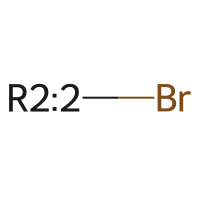
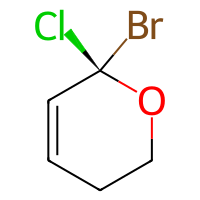
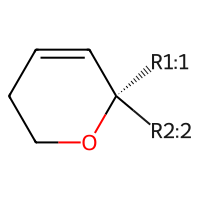
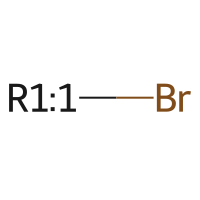
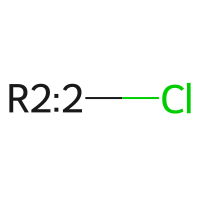
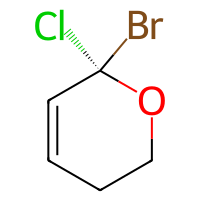
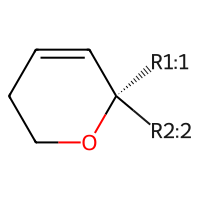
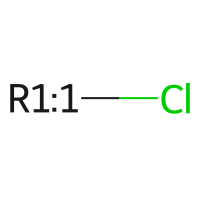
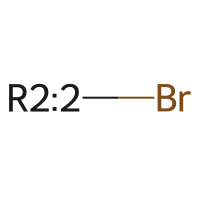
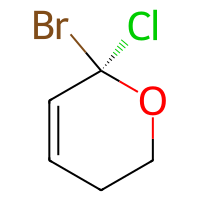
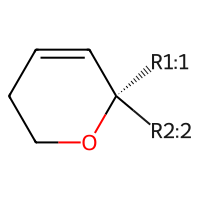
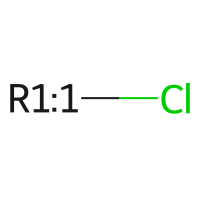
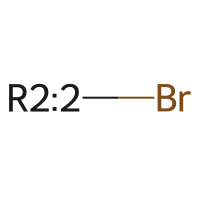
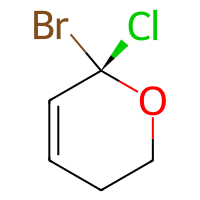
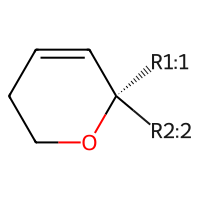
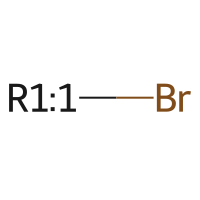
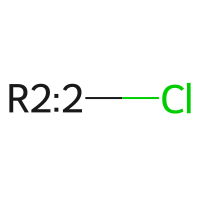

In [15]:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([chiral_scaffold,scaffold],mols,asSmiles=False,asRows=False)
PandasTools.RGroupDecompositionToFrame(groups,mols,include_core=True,redraw_sidechains=True)

# Sidechains that attach in more than one place

This one is tricky, and there's not really a right answer, this is just a demonstration of what the current code does

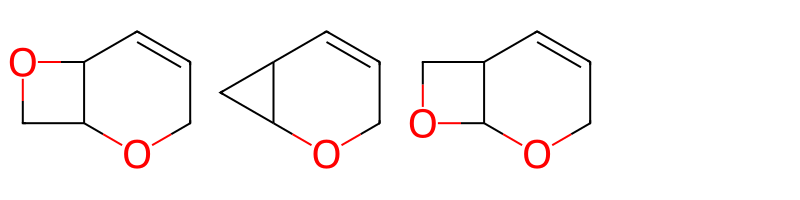

In [16]:
mols = [x for x in Chem.SDMolSupplier('../data/rgd_chiral.sdf')]
q = Chem.MolFromSmarts('[R2]')
mols = [x for x in mols if x.HasSubstructMatch(q)]
Draw.MolsToGridImage(mols,molsPerRow=4)

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,

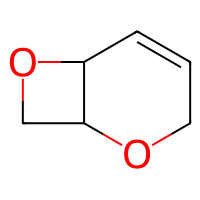
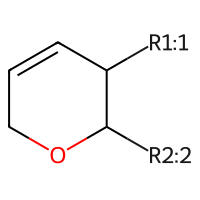
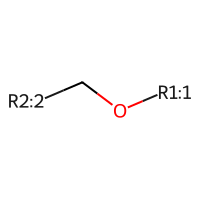
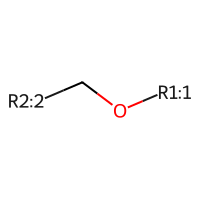
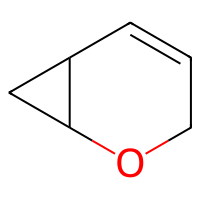
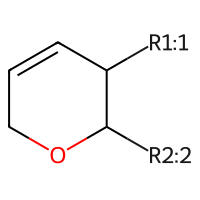
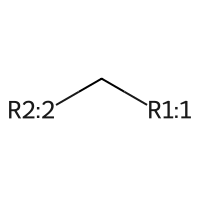
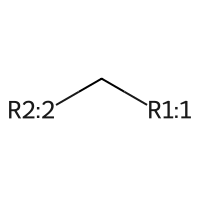
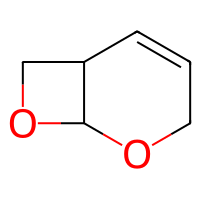
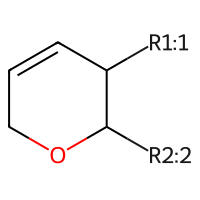
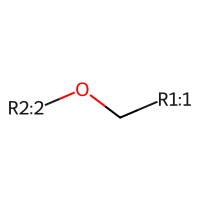
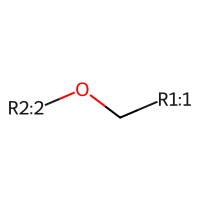

In [17]:
scaffold = Chem.MolFromSmiles('C1OCC=CC1')
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=False,asRows=False)
PandasTools.RGroupDecompositionToFrame(groups,mols,include_core=True,redraw_sidechains=True)

# Scaffold Variation

What happens if there are small variations in the scaffold within the series, something that we see all the time in med chem work?

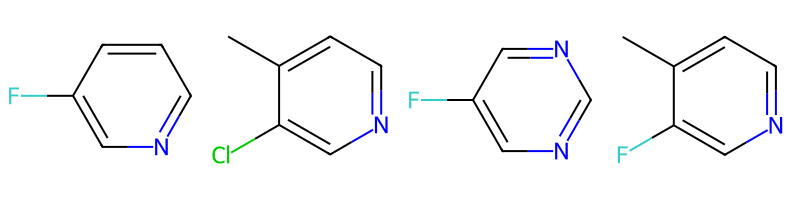

In [18]:
mols = [Chem.MolFromSmiles(smi) for smi in 'c1c(F)cccn1 c1c(Cl)c(C)ccn1 c1c(F)cncn1 c1c(F)c(C)ccn1'.split()]
Draw.MolsToGridImage(mols,molsPerRow=4)

In [19]:
scaffold = Chem.MolFromSmiles('c1c([*:1])c([*:2])ccn1')
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=True,asRows=False)
# the second return value, unmatched, provides the indices of the molecules that did not match a scaffold:
print(unmatched)
groups

[2]


[13:50:06] No core matches


{'Core': ['c1cc([*:2])c([*:1])cn1',
  'c1cc([*:2])c([*:1])cn1',
  'c1cc([*:2])c([*:1])cn1'],
 'R1': ['F[*:1]', 'Cl[*:1]', 'F[*:1]'],
 'R2': ['[H][*:2]', 'C[*:2]', 'C[*:2]']}

You can see that now we only get three results, the third molecule (index 2) didn't end up in the output.
Sometimes this is ok, but in cases like this it would be great if that molecule were also included in the R-group decomposition. 

One solution to this is to provide two different scaffolds:

[]


,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,

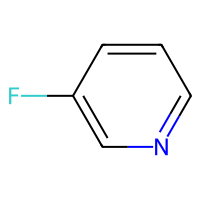
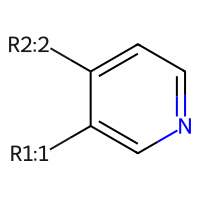
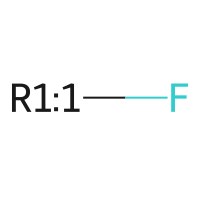
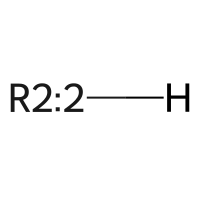
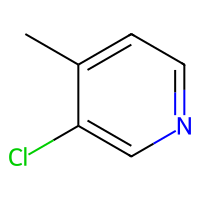
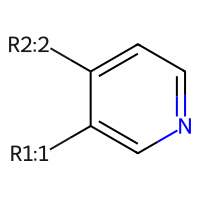
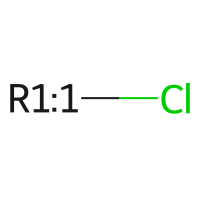
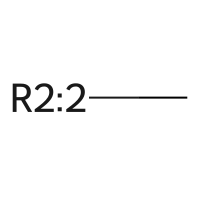
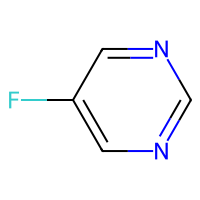
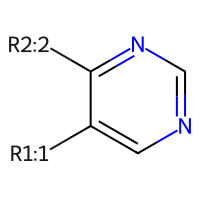
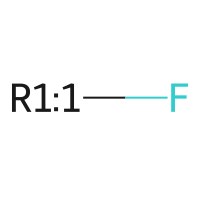
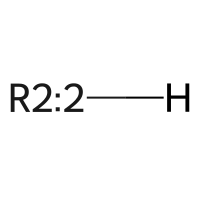
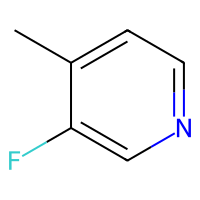
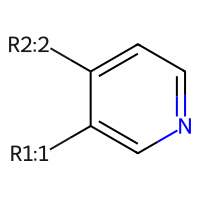
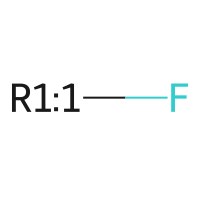
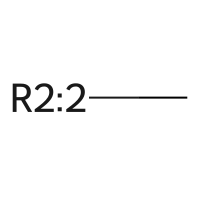

In [20]:
scaffold2 = Chem.MolFromSmiles('c1c([*:1])c([*:2])ncn1')
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([scaffold,scaffold2],mols,asSmiles=False,asRows=False)
print(unmatched)
PandasTools.RGroupDecompositionToFrame(groups,mols,include_core=True)

Notice that `unmatched` is now empty; all molecules matched one of the two cores

Another is provide the scaffold as SMARTS:

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,

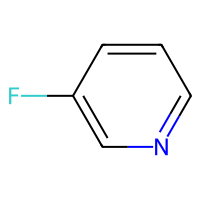
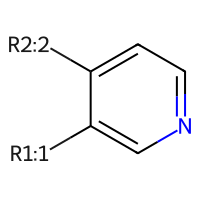
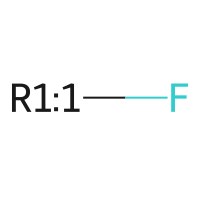
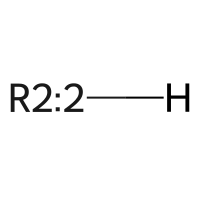
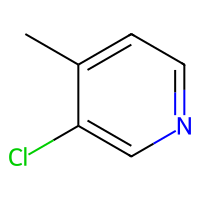
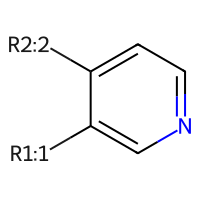
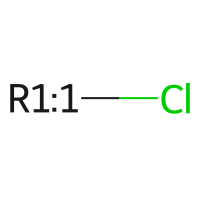
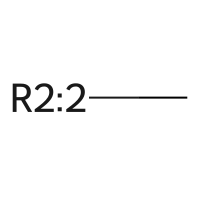
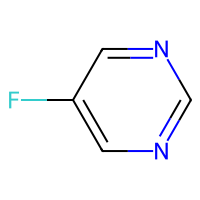
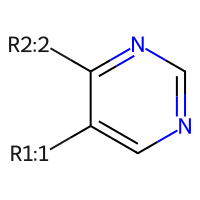
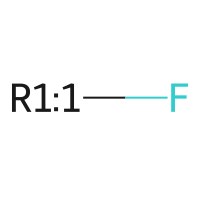
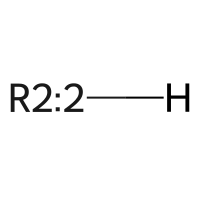
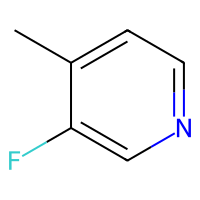
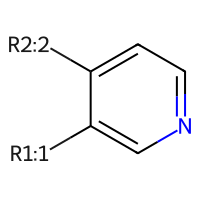
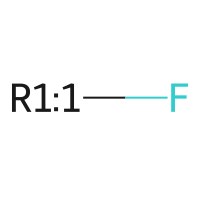
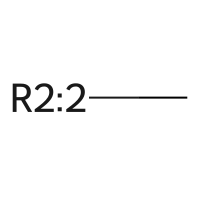

In [21]:
sma_scaffold = Chem.MolFromSmarts('c:1:c(-[*:1]):c(-[*:2]):*:c:n:1')
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([sma_scaffold],mols,asSmiles=False,asRows=False)
PandasTools.RGroupDecompositionToFrame(groups,mols,include_core=True)

# Multiple scaffolds

What about if we have multiple scaffolds which share a common SAR? Here we just provide them both and label the attachment points manually to show the correspondance.

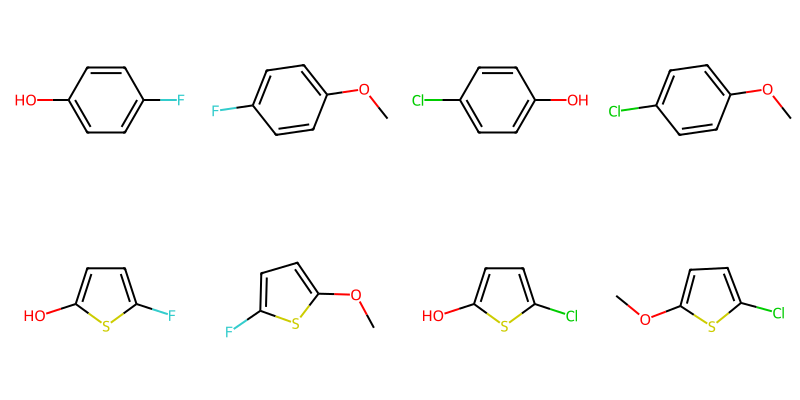

In [22]:
mols = [Chem.MolFromSmiles(smi) for smi in 'Fc1ccc(O)cc1 Fc1ccc(OC)cc1 Oc1ccc(Cl)cc1 Clc1ccc(OC)cc1 Fc1ccc(O)s1 COc1ccc(F)s1 Clc1ccc(O)s1 Clc1ccc(OC)s1'.split()]
Draw.MolsToGridImage(mols,molsPerRow=4)

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,
7,,,,

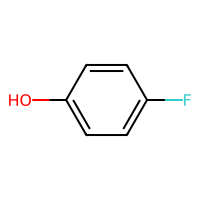
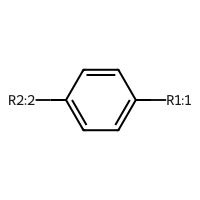
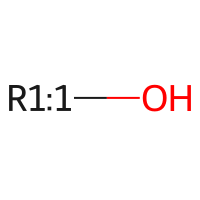
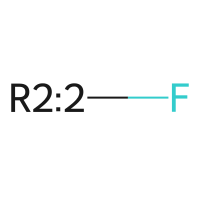
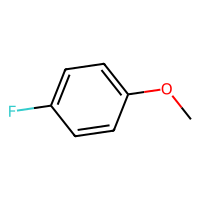
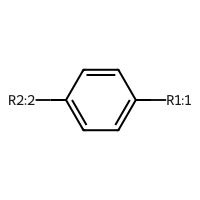
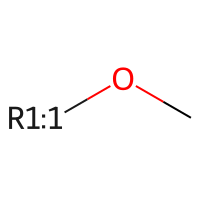
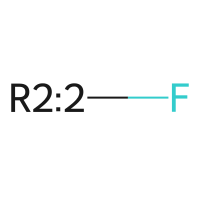
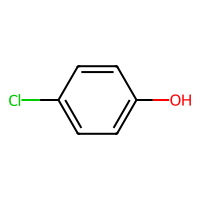
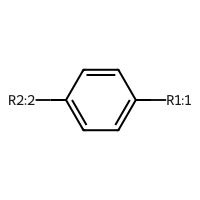
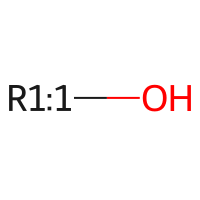
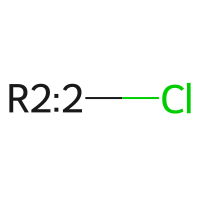
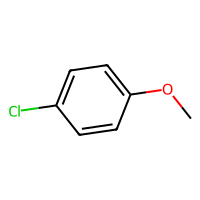
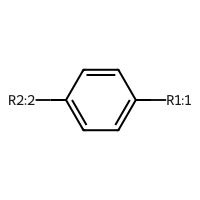
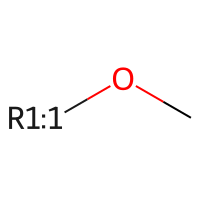
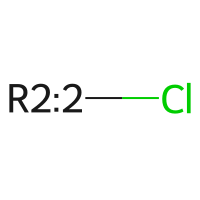
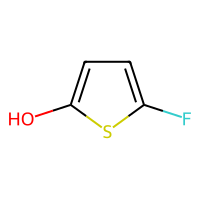
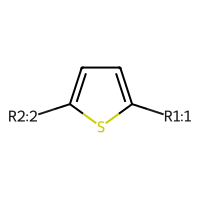
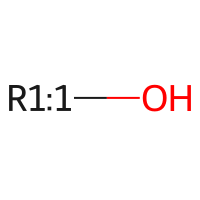
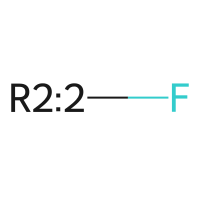
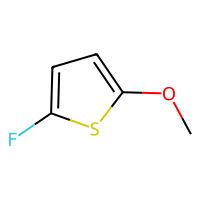
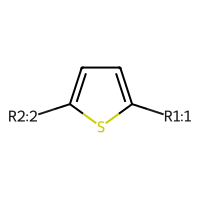
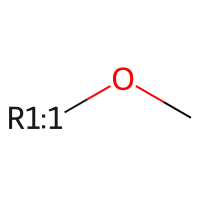
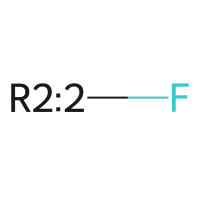
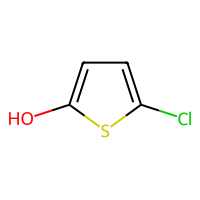
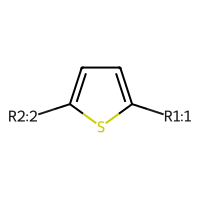
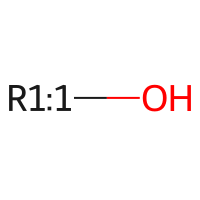
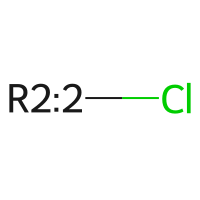
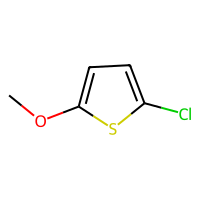
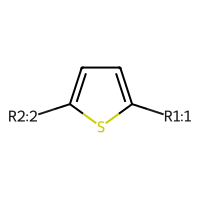
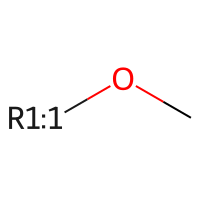
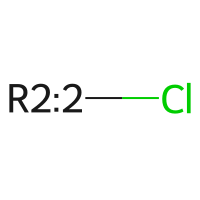

In [23]:
scaffolds = [Chem.MolFromSmiles('[*:1]c1ccc([*:2])cc1'),Chem.MolFromSmiles('[*:1]c1ccc([*:2])s1')]
groups,unmatched = rdRGroupDecomposition.RGroupDecompose(scaffolds,mols,asSmiles=False,asRows=False)
PandasTools.RGroupDecompositionToFrame(groups,mols,include_core=True)

Notice that the symmetrization also worked.

# Looking at the options that are available

We'll use a real dataset pulled from ChEMBL for this:

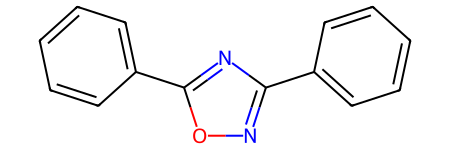

In [24]:
core = Chem.MolFromSmiles('c1ccccc1-c2nc(c1ccccc1)no2')
core

In [25]:
smiles = ['CCOCCC1(Oc2ccc(Oc3ccc(-c4nc(-c5ccccc5)no4)cc3)cc2)C(=O)NC(=O)NC1=O', 'CCOc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'CC(C)Cc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'CCOCCC1(Oc2ccc(Oc3ccc(-c4nc(-c5ccc(F)cc5)no4)cc3)cc2)C(=O)NC(=O)NC1=O', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(C5CCC5)cc4)n3)cc2)C1', 'CCOCCC1(Oc2ccc(Oc3ccc(-c4noc(-c5ccccc5)n4)cc3)cc2)C(=O)NC(=O)NC1=O', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc([C@@H]5CCC(F)(F)C5)cc4)n3)cc2)C1', 'CC(C)(C)c1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C(F)(F)F)c(C#N)c2)n1', 'Cc1cc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)ccc1OC(C)C', 'CC(C)(C)Cc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(F)c2)n1', 'COc1cc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)ccc1OC(C)C', 'CC(C)(C)c1ccc(-c2noc(-c3ccc(CN4CC(C(=O)O)C4)cc3)n2)cc1', 'Cc1cc(CCCCCC(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OCC(F)(F)F)c(C#N)c2)n1', 'CCOCCC1(Oc2ccc(Oc3ccc(-c4nc(-c5cccc(F)c5)no4)cc3)cc2)C(=O)NC(=O)NC1=O', 'Cc1ccccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'CCCCc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(C#N)c2)n1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(CCC(F)(F)F)cc4)n3)cc2)C1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(-c5ccccc5)cc4)n3)cc2)C1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(C5CCCCC5)cc4)n3)cc2)C1', 'CC[C@H](C)Oc1ccc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)cc1C#N', 'Cc1cc(CCCC(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(C(F)(F)F)c2)n1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(Cl)c2)n1', 'CCCCCCc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(Br)c2)n1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C(F)(F)F)C(F)(F)F)c(C#N)c2)n1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(C5CCCC5)cc4)n3)cc2)C1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc([C@H]5CCC(F)(F)C5)cc4)n3)cc2)C1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(C5CC5)cc4)n3)cc2)C1', 'CCCc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'CCOCCC1(Oc2ccc(Oc3ccc(-c4nc(-c5ccccc5F)no4)cc3)cc2)C(=O)NC(=O)NC1=O', 'CCC(C)(C)c1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CC(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'CC(C)Oc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(C(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'CCOc1ccc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)cc1C(F)(F)F', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'COc1ccc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)cc1C(F)(F)F']
mols = [Chem.MolFromSmiles(x) for x in smiles]

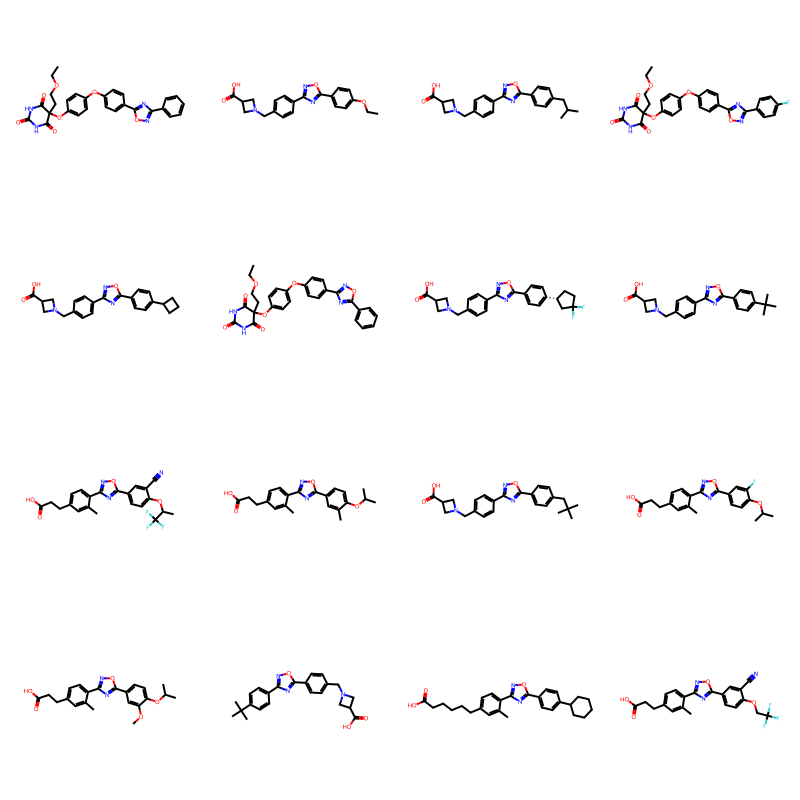

In [26]:
Draw.MolsToGridImage(mols[:16],molsPerRow=4)

,Mol,Core,R1,R2,R3,R4
0,,,,,,
1,,,,,,
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,
6,,,,,,
7,,,,,,
8,,,,,,
9,,,,,,

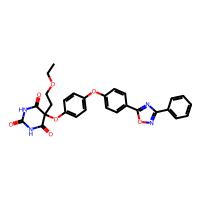
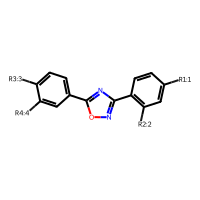
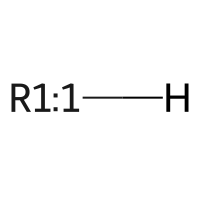
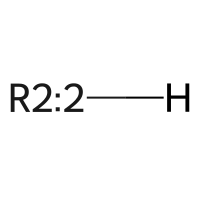
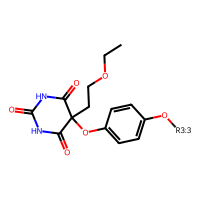
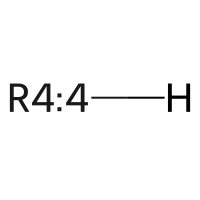
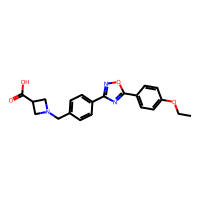
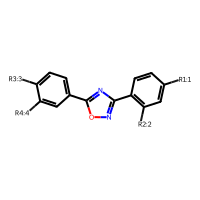
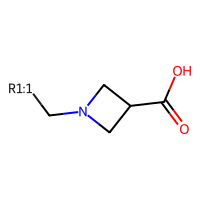
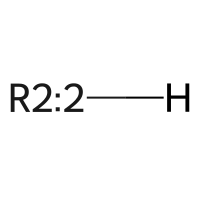
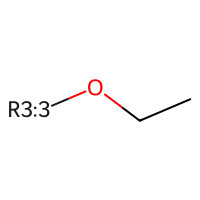
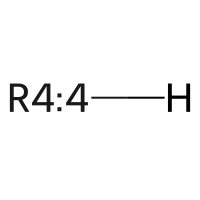
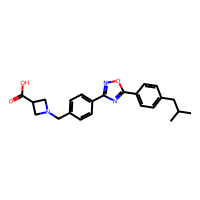
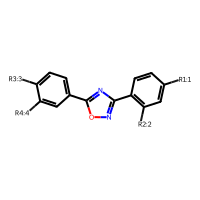
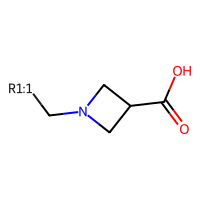
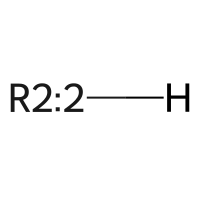
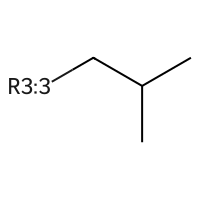
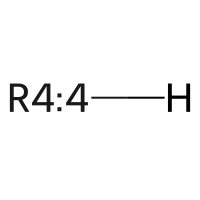
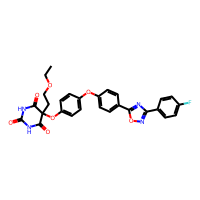
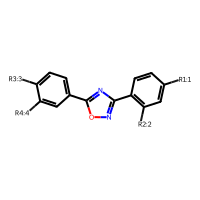
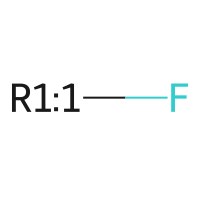
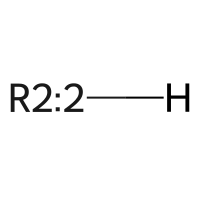
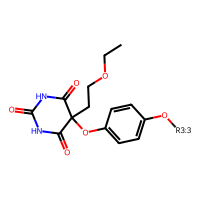
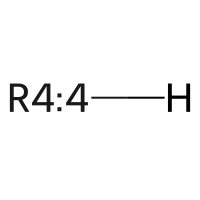
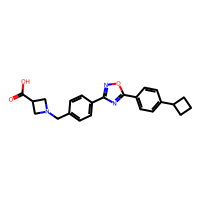
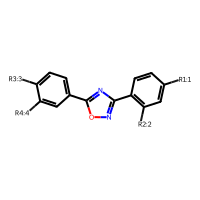
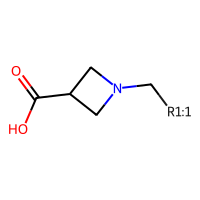
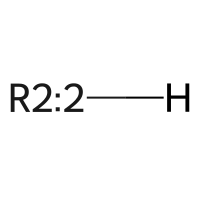
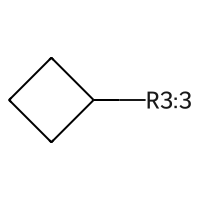
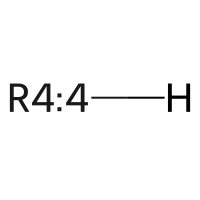
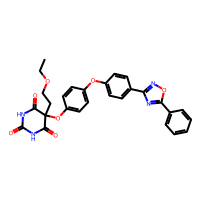
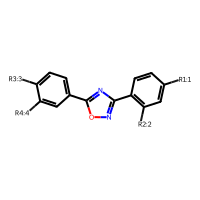
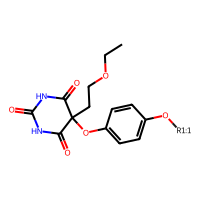
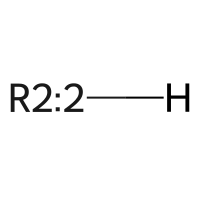
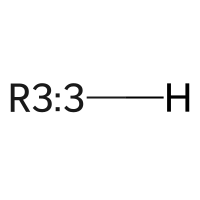
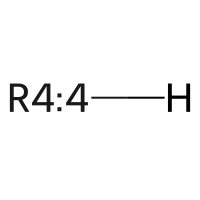
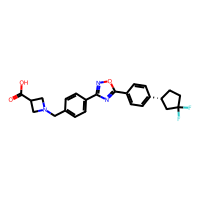
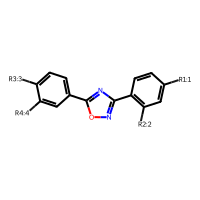
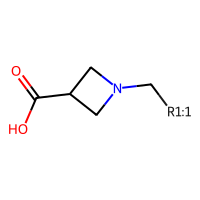
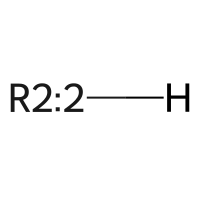
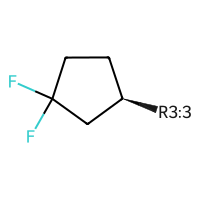
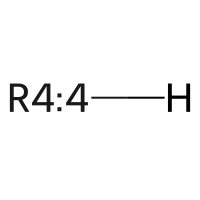
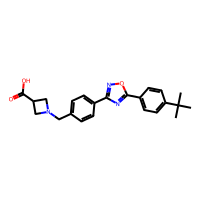
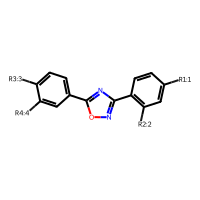
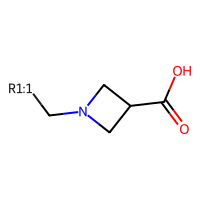
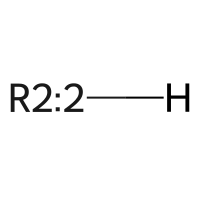
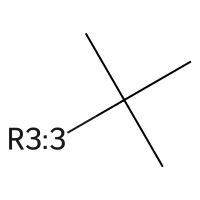
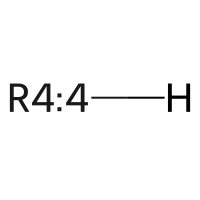
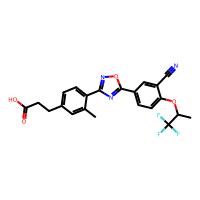
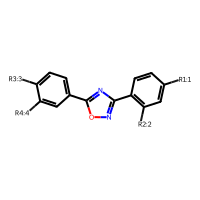
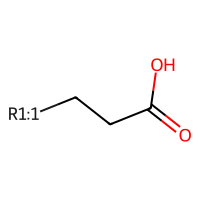
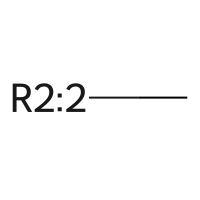
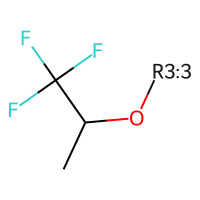
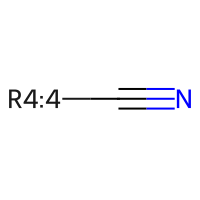
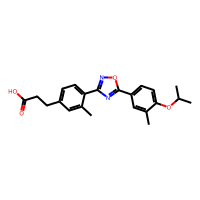
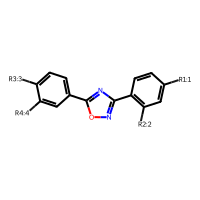
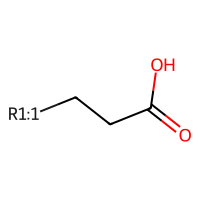
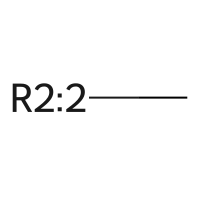
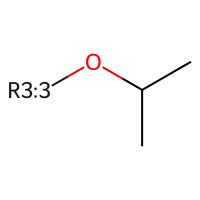
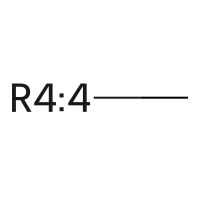
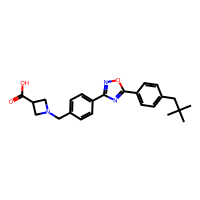
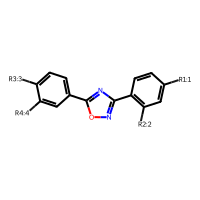
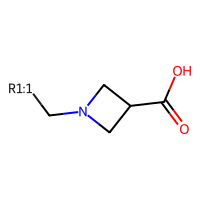
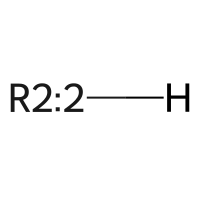
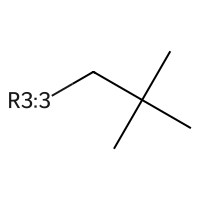
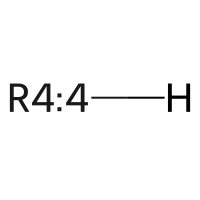
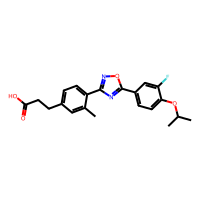
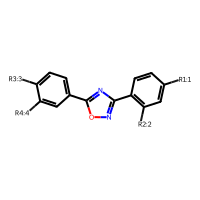
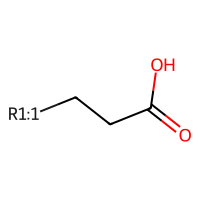
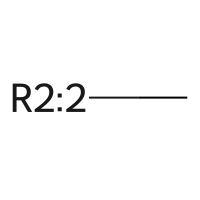
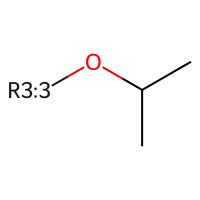
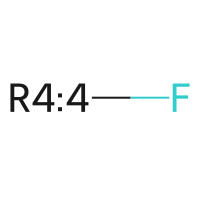
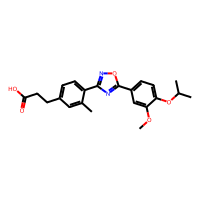
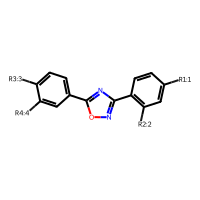
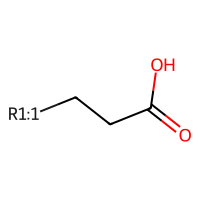
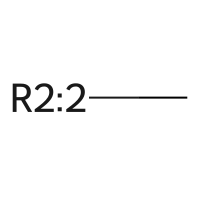
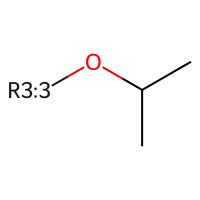
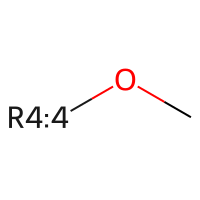
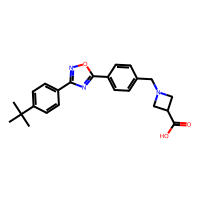
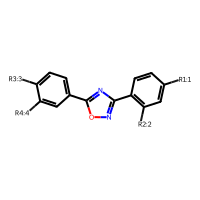
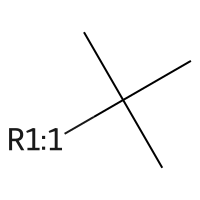
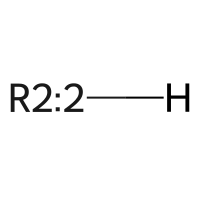
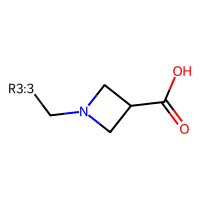
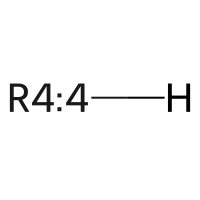
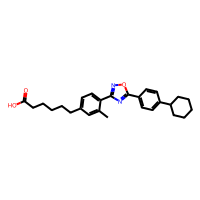
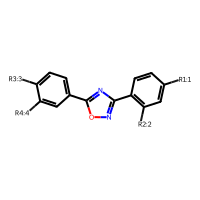
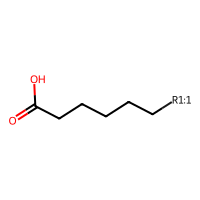
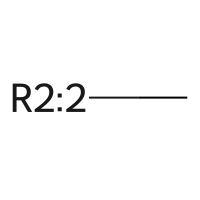
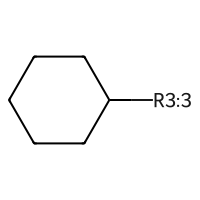
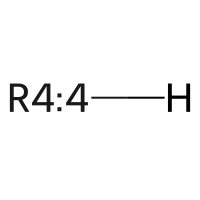
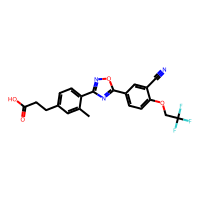
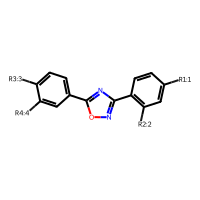
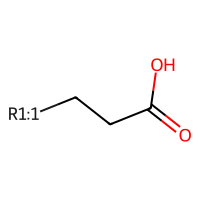
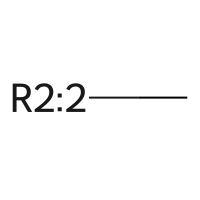
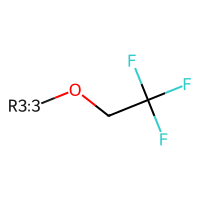
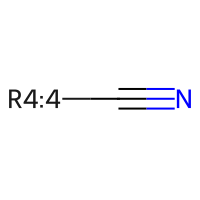

In [27]:
# we'll use just the first 16 molecules to make things a bit smaller for this demo
m16 = mols[:16]
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([core],m16,asSmiles=False,asRows=False)
PandasTools.RGroupDecompositionToFrame(groups,m16,include_core=True,redraw_sidechains=True)

Let's do a query with labelled R groups:

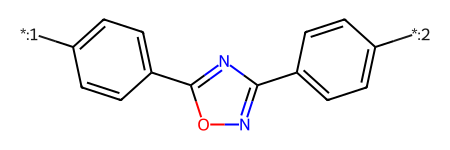

In [28]:
lcore = Chem.MolFromSmiles('c1cc([*:1])ccc1-c2nc(c1ccc([*:2])cc1)no2')
lcore

,Mol,Core,R1,R2,R3,R4
0,,,,,,
1,,,,,,
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,
6,,,,,,
7,,,,,,
8,,,,,,
9,,,,,,

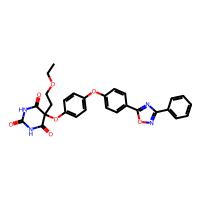
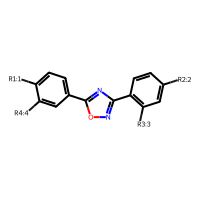
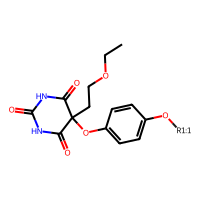
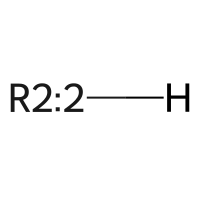
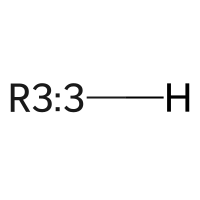
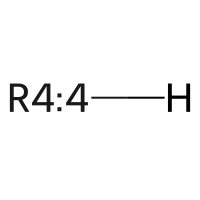
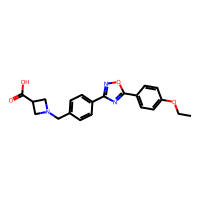
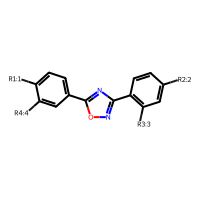
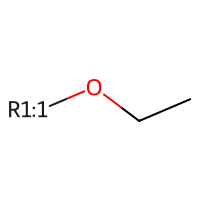
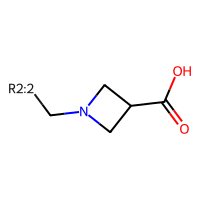
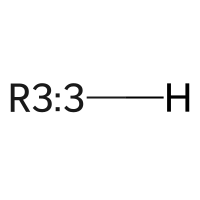
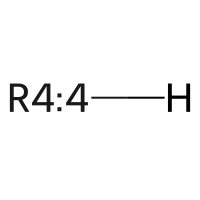
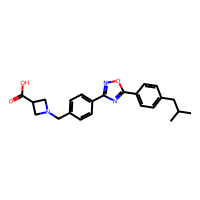
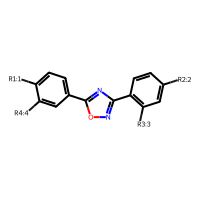
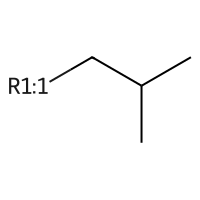
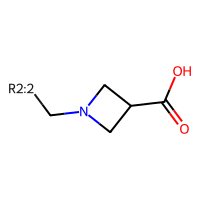
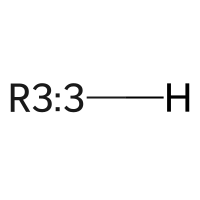
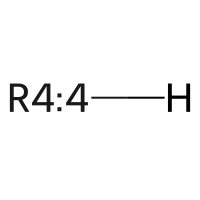
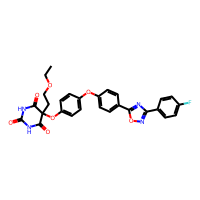
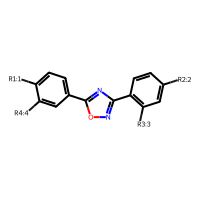
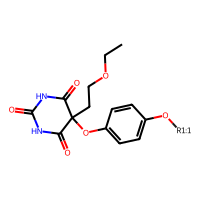
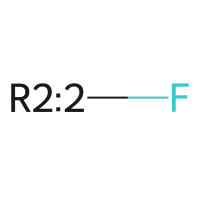
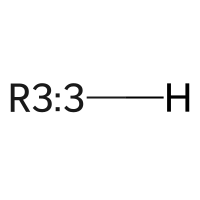
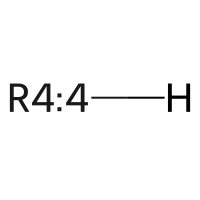
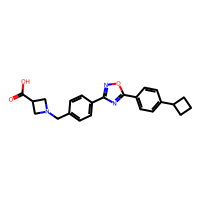
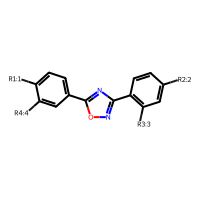
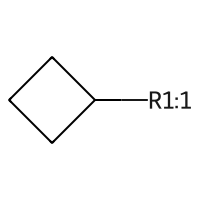
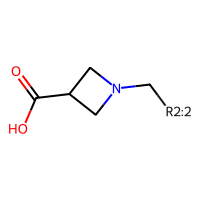
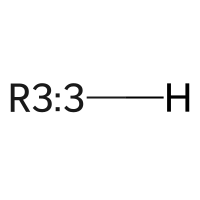
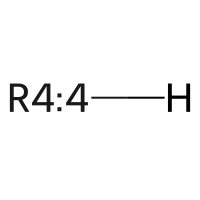
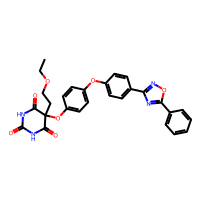
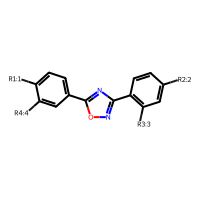
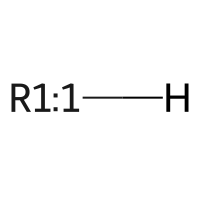
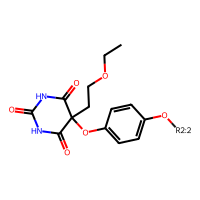
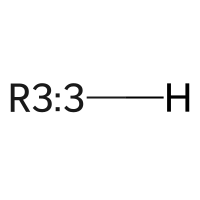
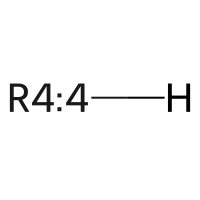
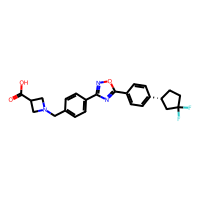
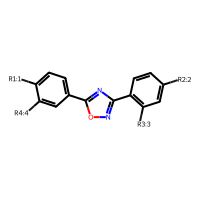
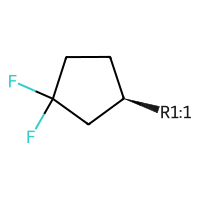
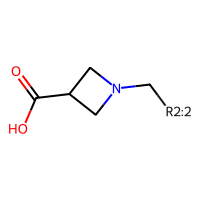
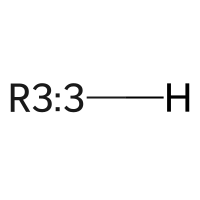
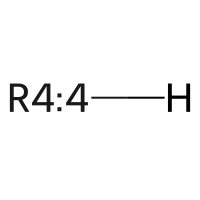
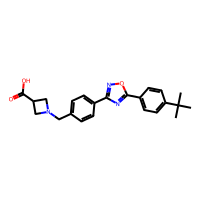
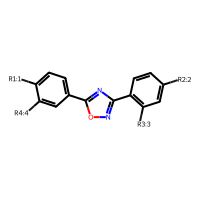
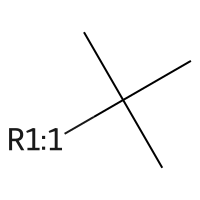
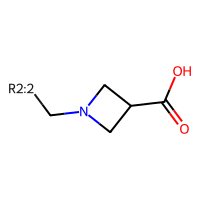
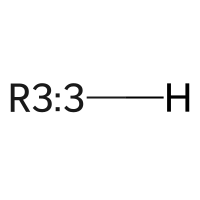
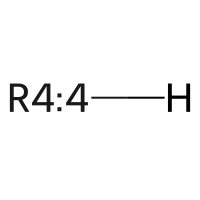
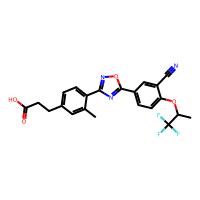
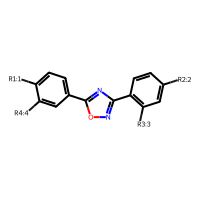
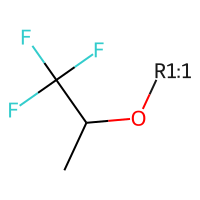
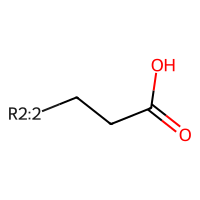
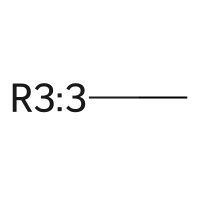
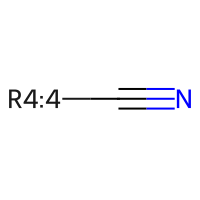
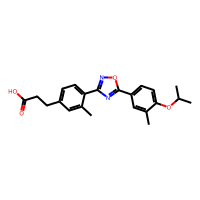
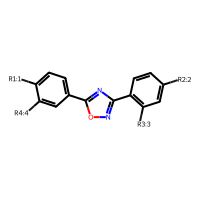
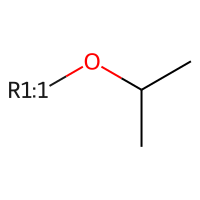
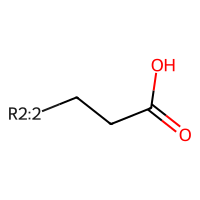
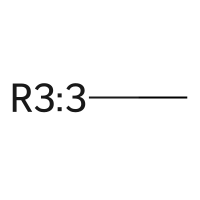
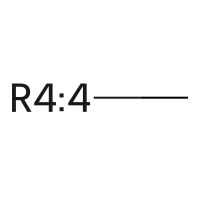
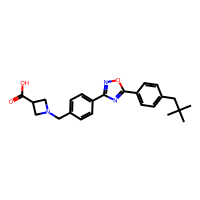
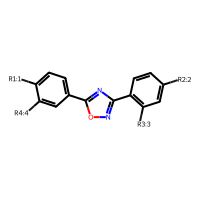
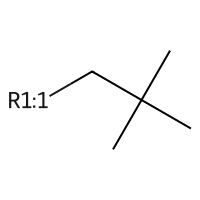
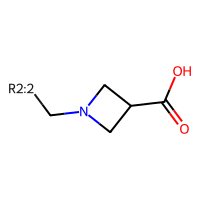
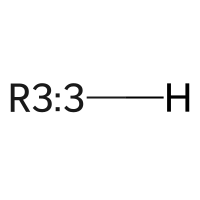
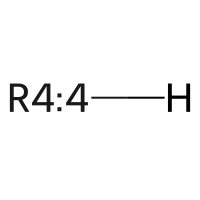
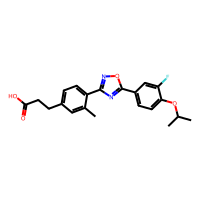
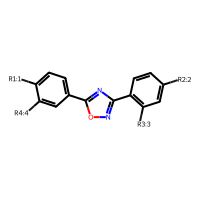
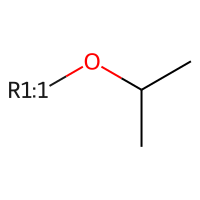
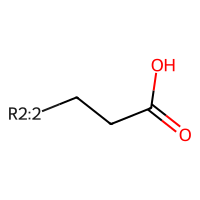
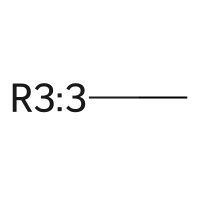
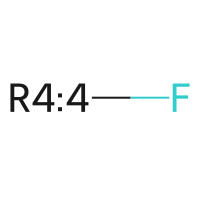
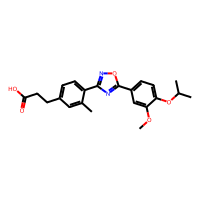
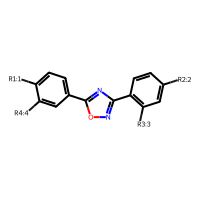
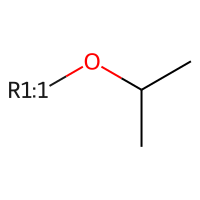
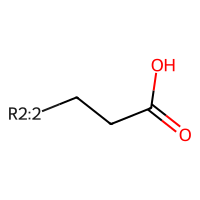
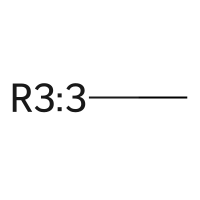
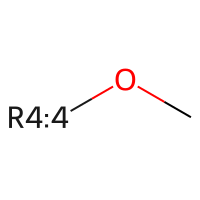
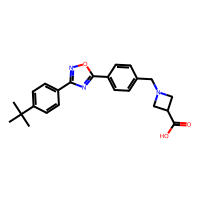
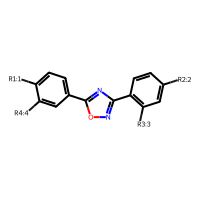
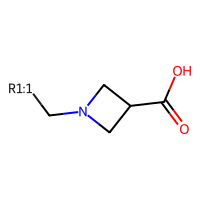
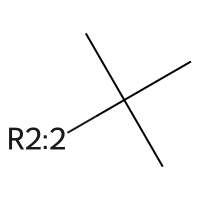
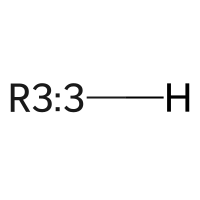
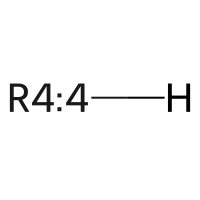
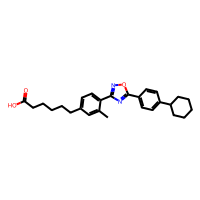
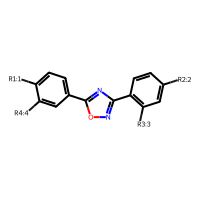
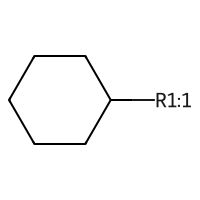
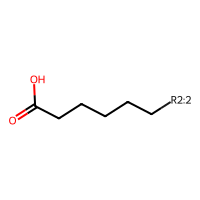
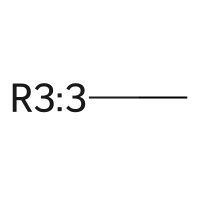
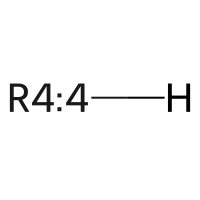
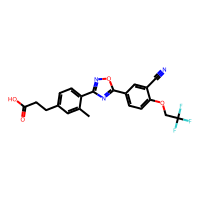
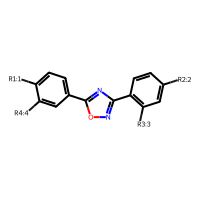
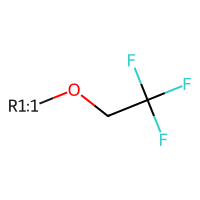
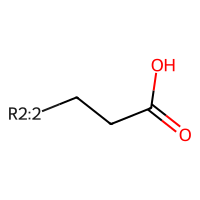
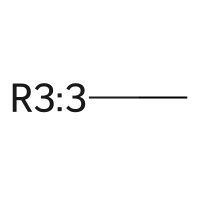
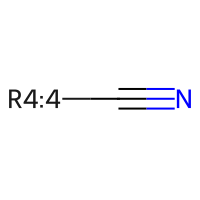

In [29]:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([lcore],m16,asSmiles=False,asRows=False)
PandasTools.RGroupDecompositionToFrame(groups,m16,include_core=True,redraw_sidechains=True)

We can exclude any molecules that have R groups in non-labelled positions:

[13:50:08] No core matches
[13:50:08] No core matches
[13:50:08] No core matches
[13:50:08] No core matches
[13:50:08] No core matches
[13:50:08] No core matches


,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,
7,,,,
8,,,,
9,,,,

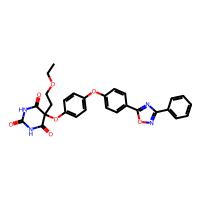
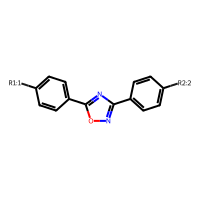
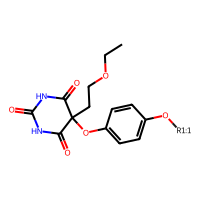
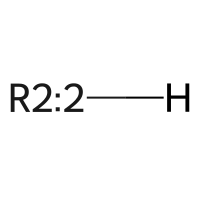
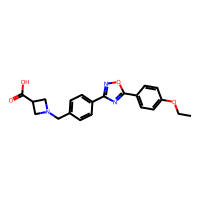
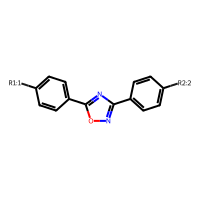
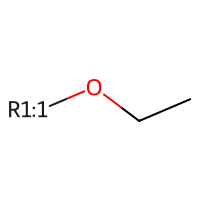
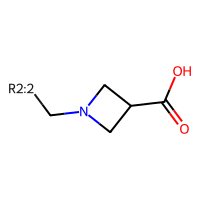
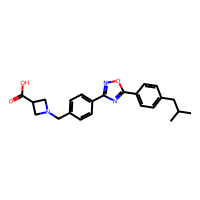
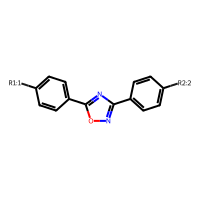
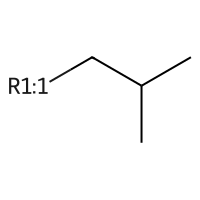
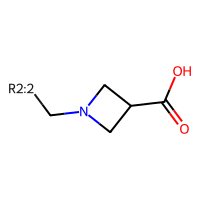
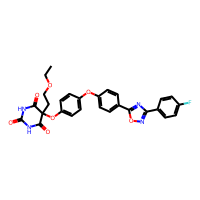
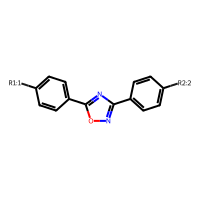
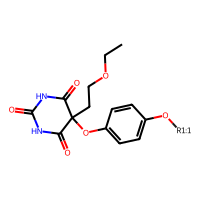
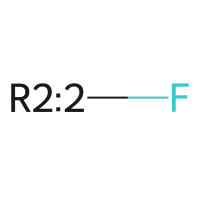
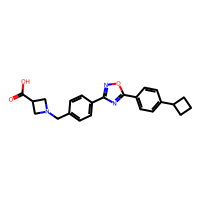
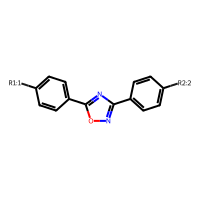
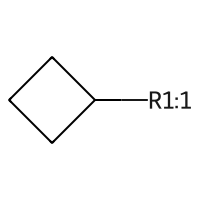
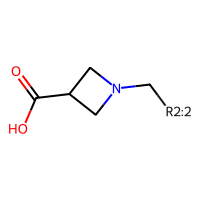
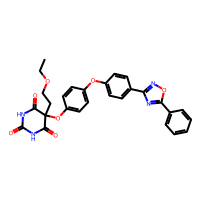
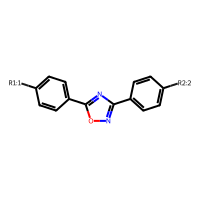
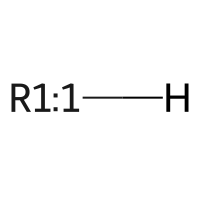
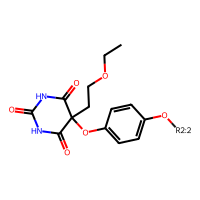
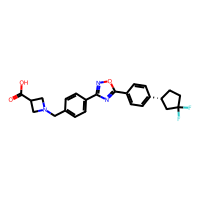
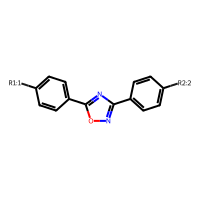
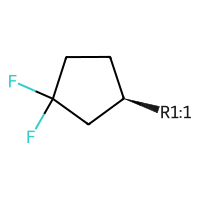
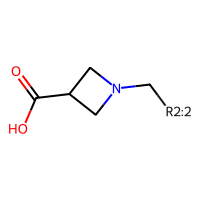
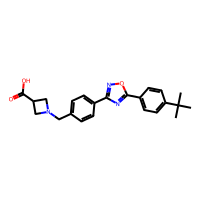
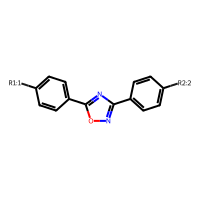
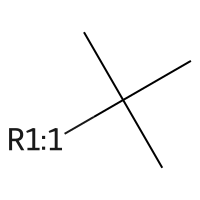
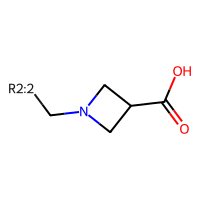
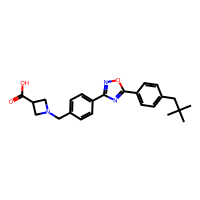
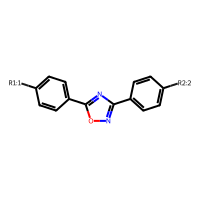
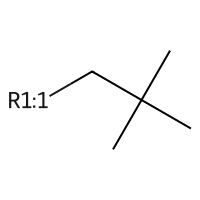
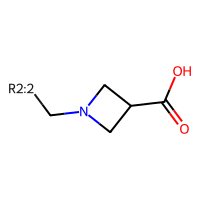
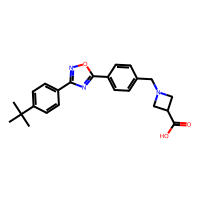
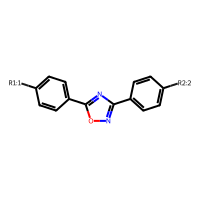
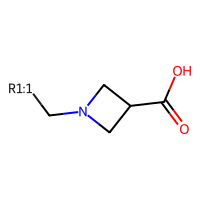
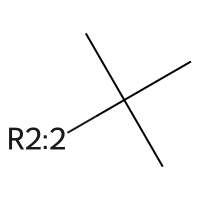

In [30]:
params = rdRGroupDecomposition.RGroupDecompositionParameters()
params.onlyMatchAtRGroups = True
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([lcore],m16,asSmiles=False,asRows=False,options=params)
tmols = [x for i,x in enumerate(m16) if i not in unmatched]
PandasTools.RGroupDecompositionToFrame(groups,tmols,include_core=True,redraw_sidechains=True)

There are other useful parameters to control the calculation in that `RGroupDecompositionParameters` object, but this post is already getting pretty long, so I'm going to wrap up now and leave exploring those as an exercise for the reader. ;-)
